# 1. Introdução

Neste notebook, exploramos uma rede complexa baseada nos dados do MMORPG **Ragnarok Online**, utilizando informações públicas da **RagnAPI**.  

### O que é o dataset?
O dataset é construído dinamicamente via API e representa as relações de "drop" entre **monstros** e **itens**.

### Definição dos nós e arestas:
- **Nós:** Monstros e Itens do jogo.
- **Arestas:** Relações direcionadas "monstro → item", indicando que o monstro pode dropar o item.

### Filtragem e subgrafos:
- Apenas monstros entre os IDs **1001** a **1100** foram utilizados.
- Itens sem conexões e monstros sem drops foram excluídos.
- Também geramos um **subgrafo conectado** para análise de medidas como diâmetro e periferia.


# 2. Setup inicial

Nesta seção, carregamos os dados em um grafo orientado DiGraph do NetworkX. Utilizamos um cache pré-coletado (monster_cache.json) contendo apenas as informações relevantes para reduzir o tempo de requisição.

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import json

with open("monster_cache.json", "r") as f:
    raw_data = json.load(f)

G = nx.DiGraph()

for m_id, data in raw_data.items():
    monster = data["name"]
    tipo = data.get("type", "normal")
    elemento = data.get("element", "neutral")
    G.add_node(monster, tipo="monstro", tipo_mob=tipo, elemento=elemento)

    for item_name in data["drops"]:
        G.add_node(item_name, tipo="item")
        G.add_edge(monster, item_name, tipo="dropa")

print(f"Grafo carregado: {G.number_of_nodes()} nós, {G.number_of_edges()} arestas")

Grafo carregado: 496 nós, 728 arestas


# 3. Matriz de Adjacência

A matriz de adjacência é uma representação da rede em forma de tabela. Cada linha e coluna corresponde a um nó, e os valores indicam se existe uma conexão entre os nós. Como o grafo é direcionado, essa matriz é assimétrica.

In [11]:
adj_matrix = nx.adjacency_matrix(G)
adj_df = pd.DataFrame(adj_matrix.todense(), index=G.nodes(), columns=G.nodes())
adj_df.iloc[:10, :10]

,red_blood,scorpion_tail,rough_elunium,solid_shell,fine_grit,yellow_herb,rusty_iron,scorpion_card,jellopy,knife,...,cultish_masque,celebrant_s_mitten,wand_of_occult,anubis_card,bug_leg,boots,argiope_card,cobweb,bark_shorts,argos_card
scorpion,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
poring,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
hornet,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
familiar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fabre,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pupa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
condor,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
willow,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chonchon,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
roda_frog,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4. Subgrafo Conectado, Diâmetro e Periferia

Essas medidas só podem ser calculadas se a rede for conectada. Como redes reais nem sempre são totalmente conectadas, usaremos a **componente fracamente conectada** mais extensa.

Diâmetro é a maior distância entre dois nós.

Periferia são os nós mais distantes dentro do grafo.

In [10]:
if not nx.is_weakly_connected(G):
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    G_sub = G.subgraph(largest_cc).copy()
else:
    G_sub = G

print(f"Subgrafo conectado com {G_sub.number_of_nodes()} nós")

G_undir = G_sub.to_undirected()
print("Diâmetro:", nx.diameter(G_undir))
print("Periferia:", nx.periphery(G_undir))

Subgrafo conectado com 487 nós
Diâmetro: 10
Periferia: ['tree_root', 'trunk', 'barren_trunk', 'solid_trunk', 'fine_grained_trunk', 'willow_card', 'circlet', 'necklace', 'cracked_diamond', 'carat_diamond', 'isis_card', 'old_purple_box', 'assassin_dagger', 'crown', 'jamadhar', 'hand_of_god', 'sphinx_hat', 'chakram', 'osiris_card', 'osiris_doll', 'heart_of_mermaid', 'fin_helm', 'saint_s_robe', 'witherless_rose', 'obeaune_card', 'full_plate', 'broadsword', 'zweihander', 'spiky_band', 'lance', 'doppelganger_card', 'green_acre_guitar', 'green_feeler', 'javelin', 'hinalle_leaflet', 'rocker_doll', 'rocker_card', 'romantic_gent', 'angel_s_reincarnation', 'gentle_breeze_guitar', 'vocal_card']


# 5. Métricas Globais da Rede

Densidade mede o quão próxima a rede está de ser totalmente conectada.

Assortatividade indica se os nós tendem a se conectar com outros de grau similar.

In [12]:
print("Densidade:", nx.density(G))
print("Assortatividade:", nx.degree_assortativity_coefficient(G))

Densidade: 0.0029651352231997393
Assortatividade: -0.13862292418907254


# 6. Histograma da Distribuição de Grau

O grau de um nó é o número de conexões que ele possui. O histograma mostra quantos nós têm determinado grau, permitindo analisar concentração e dispersão de conexões.

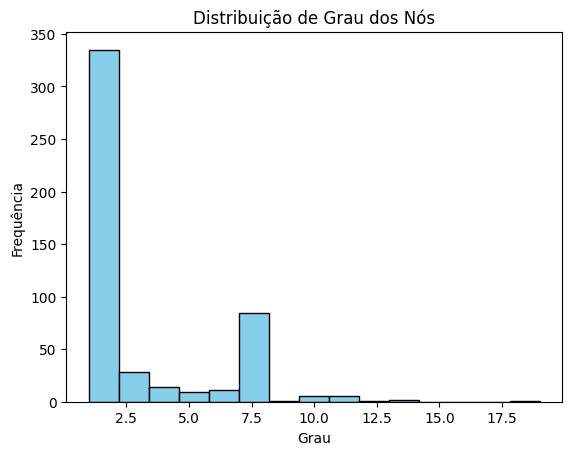

In [13]:
graus = [d for n, d in G.degree()]
plt.hist(graus, bins=15, color="skyblue", edgecolor="black")
plt.title("Distribuição de Grau dos Nós")
plt.xlabel("Grau")
plt.ylabel("Frequência")
plt.show()

# 7. Clustering

O coeficiente de clustering local mede quanto os vizinhos de um nó estão conectados entre si. Já o clustering global é a média desses valores para toda a rede.


In [18]:
clustering_local = nx.clustering(G_undir)
clustering_global = nx.average_clustering(G_undir)

# DataFrame com os nós e seus coeficientes de clustering local
clustering_df = pd.DataFrame(list(clustering_local.items()), columns=["Nó", "Clustering Local"])

# ordem decrescente
clustering_df_sorted = clustering_df.sort_values(by="Clustering Local", ascending=False)
display(clustering_df_sorted)

,Nó,Clustering Local
388,karvodailnirol,1.000000
86,hat,1.000000
83,mushroom_spore,0.500000
87,poison_spore,0.133333
82,spore,0.107143
...,...,...
158,doram_suit,0.000000
157,crimson_lance,0.000000
156,glaive,0.000000
155,,0.000000


In [19]:
print("Clustering Global:", clustering_global)

Clustering Global: 0.006057494866529773


# 8. Componentes Conectados

Componentes Fortemente Conectados: subgrupos onde existe caminho em ambos os sentidos entre todos os nós.

Componentes Fracamente Conectados: há um caminho entre todos os nós ignorando a direção.

In [20]:
print("Componentes Fortemente Conectados:", nx.number_strongly_connected_components(G))
print("Componentes Fracamente Conectados:", nx.number_weakly_connected_components(G))

Componentes Fortemente Conectados: 496
Componentes Fracamente Conectados: 2


# 9. Centralidade dos Nós

Cada métrica mostra "**importância**" de formas diferentes:

**Degree**: mais conexões.

**Closeness**: mais próximo de todos os outros.

**Betweenness**: atua como ponte.

**Eigenvector**: está bem conectado a nós importantes.

In [21]:
deg = nx.degree_centrality(G)
clo = nx.closeness_centrality(G)
bet = nx.betweenness_centrality(G)
try:
    eig = nx.eigenvector_centrality(G)
except:
    eig = {}

df_central = pd.DataFrame({
    "Nó": list(deg.keys()),
    "Degree": list(deg.values()),
    "Closeness": list(clo.values()),
    "Betweenness": list(bet.values()),
    "Eigenvector": [eig.get(n, None) for n in deg.keys()]
})

df_central.sort_values("Degree", ascending=False).head(10)

,Nó,Degree,Closeness,Betweenness,Eigenvector
30,red_herb,0.038384,0.038384,0.000000,8.829759e-06
97,rough_oridecon,0.028283,0.028283,0.000000,6.511684e-06
3,rough_elunium,0.028283,0.028283,0.000000,6.511684e-06
87,poison_spore,0.024242,0.006061,0.000061,3.535531e-01
314,mistress,0.022222,0.000000,0.000000,2.107341e-08
431,orc_hero,0.022222,0.000000,0.000000,2.107341e-08
162,anacondaq,0.022222,0.000000,0.000000,2.107341e-08
203,osiris,0.022222,0.000000,0.000000,2.107341e-08
21,green_herb,0.022222,0.023292,0.000000,3.535563e-01
423,golden_thief_bug,0.020202,0.000000,0.000000,2.107341e-08


# 10. Detecção de Comunidades (Louvain)

O algoritmo de Louvain detecta comunidades — subconjuntos de nós mais densamente conectados entre si do que com o resto da rede. Isso ajuda a entender "grupos" internos.


In [26]:
import community as community_louvain
import pandas as pd

partition = community_louvain.best_partition(G_undir)
n_comunidades = len(set(partition.values()))
print("Número de comunidades detectadas:", n_comunidades)

community_df = pd.DataFrame(list(partition.items()), columns=["Nó", "Comunidade"])

# ordenar por comunidade
community_df_sorted = community_df.sort_values(by="Comunidade", ascending=False)
display(community_df_sorted)

Número de comunidades detectadas: 15


,Nó,Comunidade
354,detrimindexta,14
297,yoyo_doll,14
298,yoyo_card,14
344,crystal_blue,14
52,meat,14
...,...,...
461,ambernite_card,0
483,argos,0
484,cobweb,0
485,bark_shorts,0
